In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from main import *

np.random.seed(0)  # For reproducibility

We will now show you how to employ our framework to obtain the ground state of a coupled system!

Consider two harmonic oscilators coupled by the Hooke's law. Let $X_j$ and $P_j$ the position and momentum operators of the $j$-th oscilator. The Hamiltonian is
$$ H =  P_1^2 + X_1^2 + P_2^2 + X_2^2 + ( X_1 - X_2)^2, $$
where we omit the factor $1/2$ for simplicity.

Among other methods for operator arithmetic, such as `addition`, `pow`, and `s_prod`, we have implemented the method `distance` on our operators to compute $|X_1 - X_2|$ returning an operator of the same kind.

We define a number of qubits for each system, and the total number of qubits will be the sum of them.

In [2]:
num_wires = 4  # qubits per system
dev = qml.device("lightning.qubit", wires=2 * num_wires)

In [3]:
wires1 = range(num_wires)
wires2 = range(num_wires, 2 * num_wires)

X1, P1 = X_and_P_ops(wires1, x_min=-3, x_max=3)
X2, P2 = X_and_P_ops(wires2, x_min=-3, x_max=3)

H12 = [X1.pow(2), X2.pow(2), P1.pow(2), P2.pow(2), distance(X1, X2).pow(2).s_prod(-0.5)]
H12

[<Hamiltonian: terms=1, wires=[0, 1, 2, 3]>,
 <Hamiltonian: terms=1, wires=[4, 5, 6, 7]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3]>,
 <Hamiltonian: terms=1, wires=[4, 5, 6, 7]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5, 6, 7]>]

We obtain the ground state and energy by ```numpy``` for comparisons.

In [4]:
H_matrix = tomatrix(H12)
vals, vecs = np.linalg.eigh(H_matrix)
val = vals[0]
vec = vecs[:, 0]

print("Ground energy: ", val)

Ground energy:  1.134591482525713


And then we define the variational ansatz. We will use a variation of the Zalka-Grover-Rudolf (ZGR) ansatz, introduced by [García-Molina et. al (2022)](https://link.aps.org/doi/10.1103/PhysRevA.105.012433), specially designed to encode continuous functions.

We will also take advantage of the evident symmetry of the system to use `symmetric_ansatz`, which takes a base ansatz on $N-1$ qubits and returns an ansatz in $N$ qubits with the same number of parameters as before. In this manner, we can impose symmetry $f(x) = f(-x)$, or antisymmetry $f(x) = - f(-x)$ in the encoded state, as shown in the publication already mentioned.

The variational ansatz is then, the ZGR followed by a symmetrization layer,

(<Figure size 4500x900 with 1 Axes>, <Axes: >)

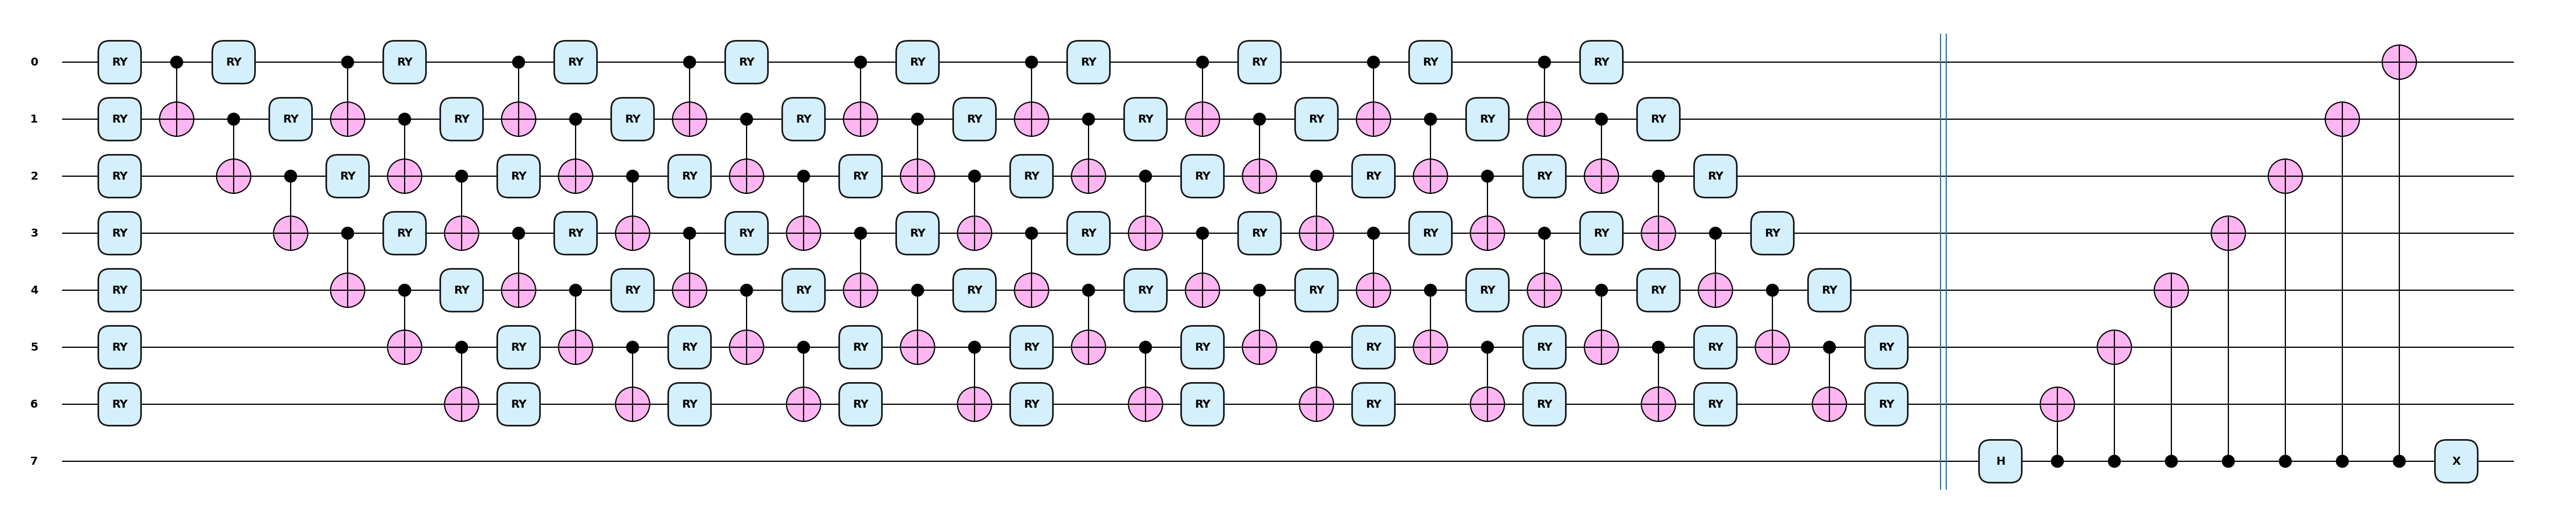

In [6]:
ansatz = RY_ansatz(2 * num_wires - 1, 10)  # Symmetrization uses the extra wire
ansatz = symmetric_ansatz(base_ansatz=ansatz)

num_params = ansatz.num_params
var_state = ansatz.construct_circuit

params = 0.0001 * np.random.randn(num_params)

# Draw ansatz
qml.draw_mpl(var_state, style="pennylane")(params)

As usual, we define our `VarFourier` instance,

In [7]:
varqft = VarFourier(H12, dev, var_state)

and perform the optimization

In [8]:
Params, Energies = varqft.run(params, max_iterations=1000, learning_rate=0.1, conv_tol=1e-6)

Step:   1000, Energy:     1.165048


In [46]:
minimum_energy = np.min(Energies)
optimum_params = Params[Energies.index(minimum_energy)]
ground_state = varqft.state(optimum_params)

print(minimum_energy,ground_state)

1.1638800938637148 [ 7.14476788e-03+0.j  3.39180775e-03+0.j  8.58494371e-03+0.j
  7.25834960e-03+0.j  8.09505102e-03+0.j  1.23745394e-02+0.j
  1.34577912e-02+0.j  1.42618473e-02+0.j  1.56365548e-02+0.j
  2.33704750e-02+0.j  2.82659731e-02+0.j  2.62419846e-02+0.j
  2.61932326e-02+0.j  2.50812535e-02+0.j  1.46894153e-02+0.j
  1.16870147e-02+0.j  6.02673058e-03+0.j -5.39863526e-05+0.j
  3.58316114e-03+0.j  3.68883120e-03+0.j  3.93783875e-03+0.j
  1.24512566e-02+0.j  1.56355384e-02+0.j  2.08372424e-02+0.j
  2.74305708e-02+0.j  3.97039084e-02+0.j  4.55639741e-02+0.j
  4.36629716e-02+0.j  4.49581393e-02+0.j  4.15770747e-02+0.j
  2.30201166e-02+0.j  1.55818637e-02+0.j  6.03735446e-03+0.j
  1.60359473e-03+0.j  3.38479369e-03+0.j  3.19466877e-03+0.j
  7.53719365e-03+0.j  1.43010455e-02+0.j  2.07692028e-02+0.j
  3.47771656e-02+0.j  4.82929034e-02+0.j  5.82326413e-02+0.j
  6.30794353e-02+0.j  6.40141692e-02+0.j  6.16781794e-02+0.j
  5.40743449e-02+0.j  3.53165300e-02+0.j  2.03667173e-02+0.j
  7.3

We can see that the grund state was indeed achieved.

In [48]:
print(optimum_params)

[ 0.01227816  0.037806   -0.05452331 -0.23721232  0.34868701  0.09326328
 -0.93408295 -0.20502922 -0.32821435  0.06583843  1.52154844  0.22270406
  1.56562052 -0.64283873 -0.2517259  -1.77329842  0.23403482 -1.77277981
 -1.85361646 -0.00449433 -0.00863162 -0.38905901 -0.75625309 -0.35141546
 -0.08763948  0.04045301  0.04973511  0.01687884  0.05601027 -0.06250033
 -0.10016428  0.02424824  0.03578448 -0.02556002 -0.0716167   0.05400008
  1.35036859  0.07063188  0.10048793 -1.95297598  0.04202041 -0.01785988
 -0.04326282  1.21605842 -2.15063788 -0.01672401  0.07191456 -0.00609432
 -0.01436737 -0.00763739  0.23242062 -1.58111376  0.03367787 -0.2939006
 -0.04472937 -0.33845391  1.58232945 -0.6107395  -2.71990852 -0.05454273
 -0.01654574 -2.46059517  3.05892128 -0.05680558 -0.00827914 -0.00669142
 -0.00677604  0.13335335 -0.16760787 -0.08099663]


In [50]:
np.save('optimum_params_coupled',optimum_params)
np.save('optimum_state',ground_state)
np.save('exact_state', vec)

In [5]:
ground_state = np.load('optimum_state.npy')
vec = np.load('exact_state.npy')

NameError: name 'Energies' is not defined

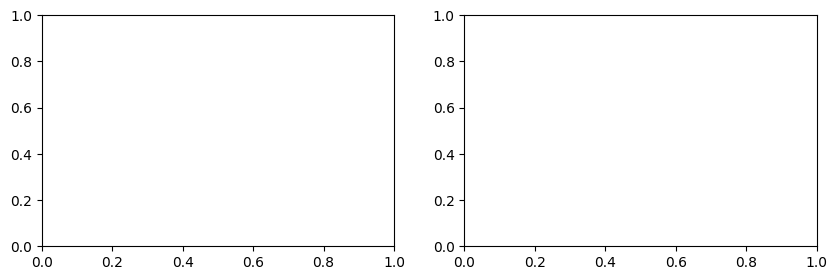

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

#ground_state = varqft.state(Params[-1])

ax[0].plot(Energies)
ax[0].hlines(val, 0, len(Energies), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 0]) ** 2)
ax[1].plot(np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

However, the state currently has the encoding of the physical space of each system mixed up. To visualize it correctly, we can
reorder it and show the probability distribution in $2$ dimensions.

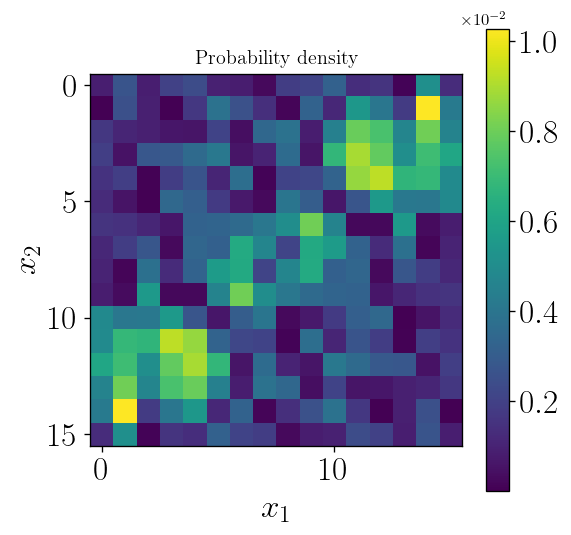

In [53]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker


M1 = ground_state.reshape(2**num_wires, 2**num_wires)

M2 = vec.reshape(2**num_wires, 2**num_wires)

M = np.abs(-M1-M2)

fig,ax = plt.subplots(1,1, figsize=(5,5))

im = ax.imshow(M, cmap = cm.viridis)
plt.title("Probability density")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbformat = ScalarFormatter(useMathText=True)   # create the formatter
cbformat.set_powerlimits((-0,0)) 

ax.set_xlabel(r'$x_1$', fontsize = 20)
ax.set_ylabel(r'$x_2$', fontsize = 20)
#ax.set_zlabel(r"$\left|\psi(x)\right|^2$",fontsize=15)
ax.tick_params(axis='both', labelsize=20)
cbar = fig.colorbar(im, ax=ax, format=cbformat)
cbar.ax.tick_params(labelsize=20)  # Change the number (10) to adjust the size

#cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))


plt.savefig("difwfs_coupled_oscillators_viridis.pdf",bbox_inches='tight',dpi=600)


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

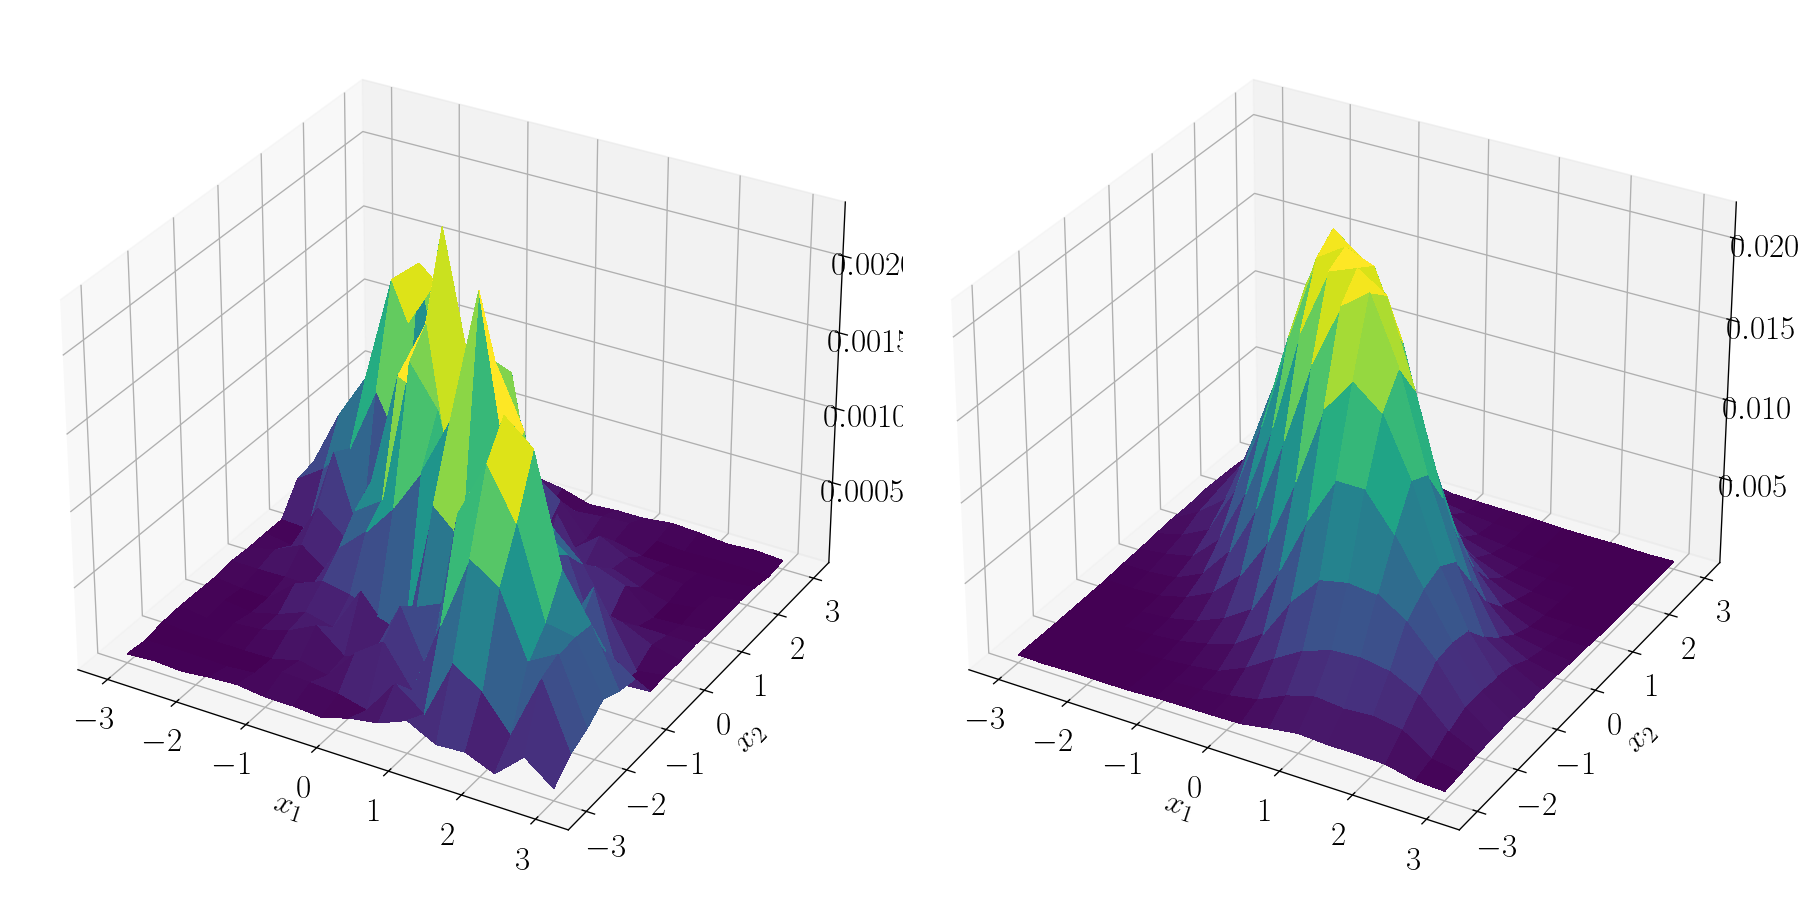

In [9]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x = np.linspace(-3,3,2**num_wires)
y = np.linspace(-3,3,2**num_wires)
X,Y = meshgrid(x, y)
surf = ax.plot_surface(X, Y, np.abs(M) , rstride=1, cstride=1,
                      cmap=cm.viridis,linewidth=0, antialiased=False)
ax.set_xlabel(r'$x_1$', fontsize = 20)
ax.set_ylabel(r'$x_2$', fontsize = 20)
#ax.set_zlabel(r"$\left|\psi(x)\right|^2$",fontsize=15)
ax.tick_params(axis='both', labelsize=20)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X, Y, np.abs(ground_state.reshape(2**num_wires, 2**num_wires))**2 , rstride=1, cstride=1,
                      cmap=cm.viridis,linewidth=0, antialiased=False)
ax2.set_xlabel(r'$x_1$', fontsize = 20)
ax2.set_ylabel(r'$x_2$', fontsize = 20)
#ax2.set_zlabel(r"$\left|\psi(x)\right|^2$",fontsize=15)
ax2.tick_params(axis='both', labelsize=20)
plt.tight_layout()

In [ ]:
inner